<a href="https://colab.research.google.com/github/Harithanush/EmotionDetection/blob/main/RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
with zipfile.ZipFile('/content/archive (1) (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Accuracy after tuning: 95.54%

Confusion Matrix:
 [[ 905    0    4   16   12   19    2]
 [   2  107    0    0    0    2    0]
 [  12    0  953   22    8   20    9]
 [   3    0    3 1739   11   13    5]
 [   7    0    3   30 1173   17    3]
 [   5    0    7   36   20 1176    3]
 [   5    0    2    6    7    6  805]]

Classification Report:
               precision    recall  f1-score   support

       angry       0.96      0.94      0.95       958
     disgust       1.00      0.96      0.98       111
        fear       0.98      0.93      0.95      1024
       happy       0.94      0.98      0.96      1774
     neutral       0.95      0.95      0.95      1233
         sad       0.94      0.94      0.94      1247
    surprise       0.97      0.97      0.97       831

    accuracy                           0.96      7178
   macro avg       0.96      0.95      0.96      7178
weighted avg       0.96      0.96      0.96      7178



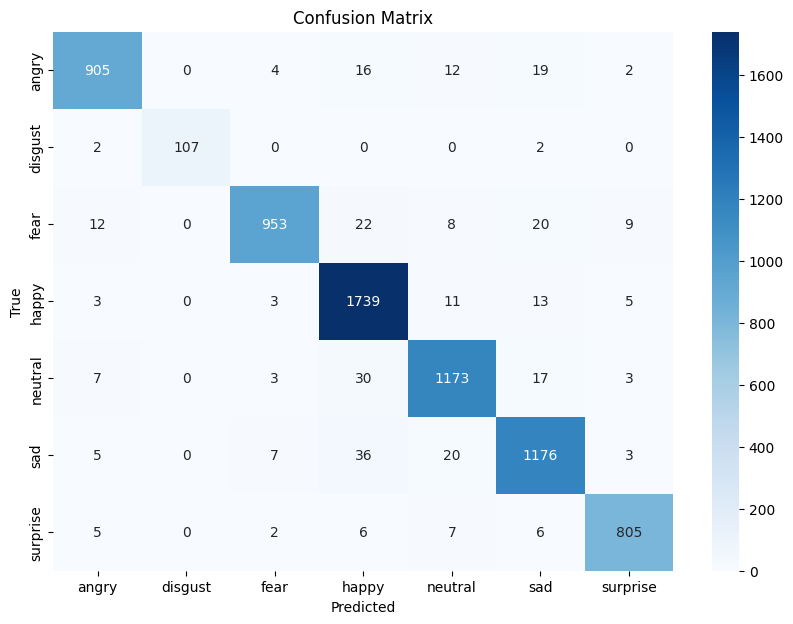

The predicted emotion for the uploaded image is: neutral


In [ ]:
import os
import numpy as np
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Load and preprocess dataset
def load_images_for_rf(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            img = cv2.resize(img, (48, 48))  # Resize to 48x48 for consistency
            if img is not None:
                # Extract HOG features
                hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
                images.append(hog_features)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load train and test sets
train_dir = '/content/train'
val_dir = '/content/test'
X_train, y_train = load_images_for_rf(train_dir)
X_test, y_test = load_images_for_rf(val_dir)

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=150)  # Reduce feature space while retaining important information
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define a parameter grid for Random Forest optimization
param_dist = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'max_depth': [10, 20, 50, None],  # Max depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples in a leaf node
    'bootstrap': [True, False],       # Whether to bootstrap samples
    'max_features': ['sqrt', 'log2', None]  # Use 'sqrt', 'log2', or None for max_features
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search.fit(X_train_pca, y_train_encoded)

# Use the best parameters found during RandomizedSearchCV
best_rf = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy after tuning: {accuracy * 100:.2f}%")

# Generate confusion matrix and classification report
cm = confusion_matrix(y_test_encoded, y_pred)
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Function to test and predict a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img = cv2.resize(img, (48, 48))  # Resize to 48x48
    hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    hog_features_scaled = scaler.transform([hog_features])  # Scale the features
    hog_features_pca = pca.transform(hog_features_scaled)  # Transform with PCA
    return hog_features_pca

def predict_emotion(image_path, model):
    img_features = preprocess_image(image_path)
    predicted_label = model.predict(img_features)
    return label_encoder.inverse_transform(predicted_label)[0]

# Example usage: Predict the emotion of a new uploaded image
uploaded_image_path = '/content/test/neutral/PrivateTest_10767287.jpg'  # Change this to the path of the uploaded image
predicted_emotion = predict_emotion(uploaded_image_path, best_rf)
print(f'The predicted emotion for the uploaded image is: {predicted_emotion}')


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_rf, X_train_pca, y_train_encoded, cv=kf, scoring='accuracy')

print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean():.2f} ± {cross_val_scores.std():.2f}")


Cross-Validation Scores: [0.4773598  0.47823058 0.47997214 0.49303379 0.47517854]
Mean Cross-Validation Score: 0.48 ± 0.01


In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

# Define your classifier (RandomForestClassifier in this case)
best_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_rf,
    X=X_train_pca,  # Training data
    y=y_train_encoded,  # Training labels
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',  # Metric to evaluate
    n_jobs=-1,  # Use all available processors
    train_sizes=np.linspace(0.1, 1.0, 5),  # 5 increments from 10% to 100% of training set
    random_state=42
)

# Compute mean and standard deviation of train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


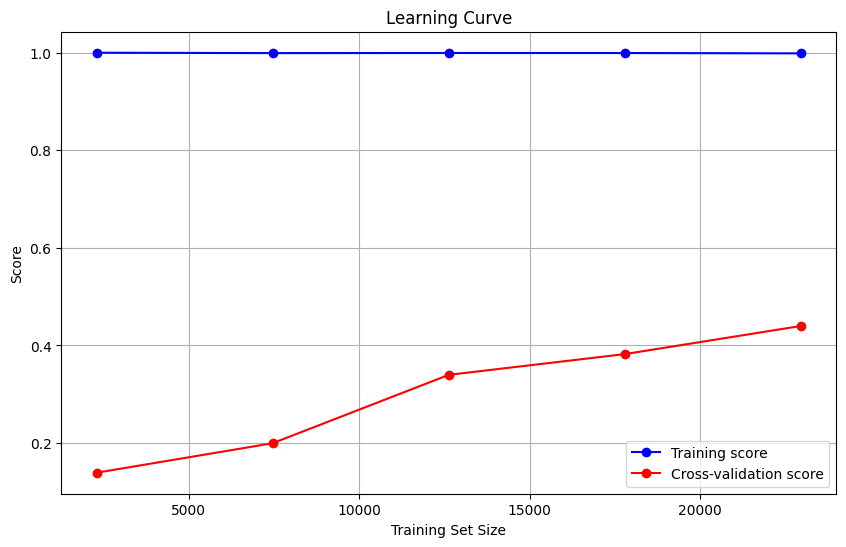

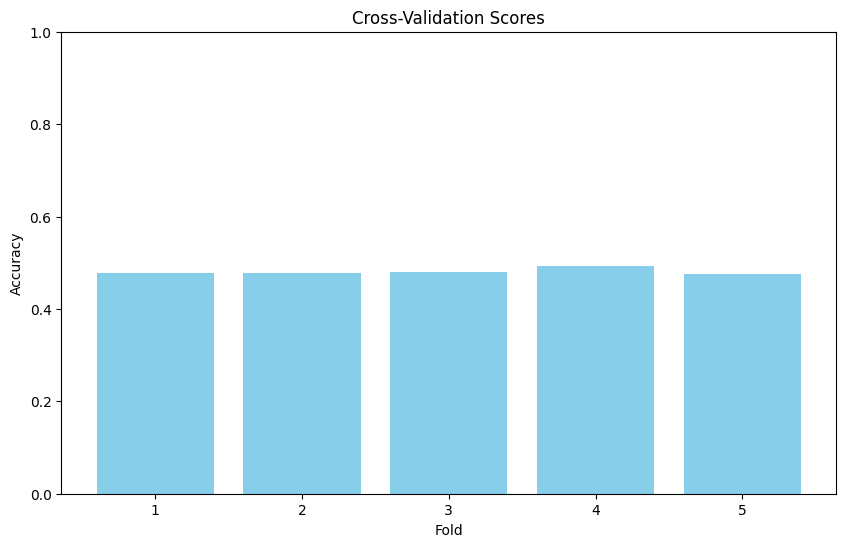

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot learning curve
def plot_learning_curve(train_sizes, train_scores, test_scores):
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color='red', label="Cross-validation score")

    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Function to plot cross-validation results
def plot_cross_validation_scores(cv_scores):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='skyblue')
    plt.title('Cross-Validation Scores')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.show()


plot_learning_curve(train_sizes, train_scores, test_scores)

# Plot cross-validation scores
plot_cross_validation_scores(cross_val_scores)